# Marketing Mix Modelling
In this project we analyse marketing spends data and try to understand its relationship with sales for that calendar week. Using insights from the above analysis we will build a forecasting model.

The "mix" in Marketing Mix Modeling comes from analyzing how different marketing activities work together to drive sales, rather than looking at each channel in isolation.

This notebook covers:
- Exploratory data anlaysis through data visualization
- Outlier detection and treatment using IQR rule
- Feature engineering marketing channels, specifically with the week column
- Controlling for base sales and seasonality (time components)
- Modeling the AdStock effect using a decay constant (log(x_i) + d*x_{i-1})
- Using pd.get_dummies for categorical feature processing
- Feature scaling with MinMaxScaler (x - x_min)/(x_max - x_min)
- Cross validation with RepeatedKFold, using R2 score
- Variance Inflation Factor used to drop redundant features (marketing channel collinearity; correlation heatmap can help visualize which features these are)

### Importing Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading Data and Basic Data Understanding

In [46]:
df =  pd.read_csv('../raw_data/sample_media_spend_data.csv')
df.columns = map(str.lower, df.columns)
df = df[:-1].reset_index(drop = True)
final_test = df[-1:]

In [47]:
df.columns

Index(['division', 'calendar_week', 'paid_views', 'organic_views',
       'google_impressions', 'email_impressions', 'facebook_impressions',
       'affiliate_impressions', 'overall_views', 'sales'],
      dtype='object')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   division               3050 non-null   object 
 1   calendar_week          3050 non-null   object 
 2   paid_views             3050 non-null   int64  
 3   organic_views          3050 non-null   int64  
 4   google_impressions     3050 non-null   int64  
 5   email_impressions      3050 non-null   float64
 6   facebook_impressions   3050 non-null   int64  
 7   affiliate_impressions  3050 non-null   int64  
 8   overall_views          3050 non-null   int64  
 9   sales                  3050 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 238.4+ KB


In [49]:
df.describe()

,paid_views,organic_views,google_impressions,email_impressions,facebook_impressions,affiliate_impressions,overall_views,sales
count,3050.000000,3050.000000,3.050000e+03,3.050000e+03,3.050000e+03,3050.000000,3050.000000,3.050000e+03
mean,15093.647869,13351.201967,8.863172e+05,7.606148e+05,2.691622e+05,22915.039344,27975.991803,1.859302e+05
std,30790.928809,24082.081303,1.355275e+06,6.260897e+05,4.665841e+05,21619.974449,52062.802215,2.322405e+05
min,1.000000,1.000000,7.000000e+00,4.089445e+04,2.900000e+01,910.000000,2.000000,1.543600e+04
25%,536.000000,712.250000,1.698070e+05,3.784388e+05,5.707025e+04,9121.500000,747.000000,7.339225e+04
50%,2689.500000,4103.000000,4.905315e+05,5.912425e+05,1.275080e+05,16661.000000,7838.500000,1.136850e+05
75%,17362.000000,16209.500000,1.023151e+06,9.625489e+05,2.835165e+05,27487.250000,34102.750000,2.030378e+05
max,518190.000000,270453.000000,1.715044e+07,7.317730e+06,7.558435e+06,175791.000000,635057.000000,3.575430e+06


In [50]:
def get_num_cat_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num = df.select_dtypes(include=numerics).columns.to_list()
    cat = df.select_dtypes(include=['object']).columns.to_list()
    return num, cat

In [51]:
numeric_columns, categorical_columns  = get_num_cat_columns(df)
numeric_columns, categorical_columns

(['paid_views',
  'organic_views',
  'google_impressions',
  'email_impressions',
  'facebook_impressions',
  'affiliate_impressions',
  'overall_views',
  'sales'],
 ['division', 'calendar_week'])

In [52]:
for col in categorical_columns:
    print(df[col].value_counts())

division
Z    225
B    113
Y    113
X    113
W    113
V    113
U    113
T    113
S    113
R    113
Q    113
P    113
O    113
A    113
M    113
L    113
K    113
J    113
I    113
H    113
G    113
F    113
E    113
D    113
C    113
N    113
Name: count, dtype: int64
calendar_week
1/6/2018     27
2/9/2019     27
8/10/2019    27
8/3/2019     27
7/27/2019    27
             ..
9/1/2018     27
8/25/2018    27
8/18/2018    27
8/11/2018    27
2/29/2020    26
Name: count, Length: 113, dtype: int64


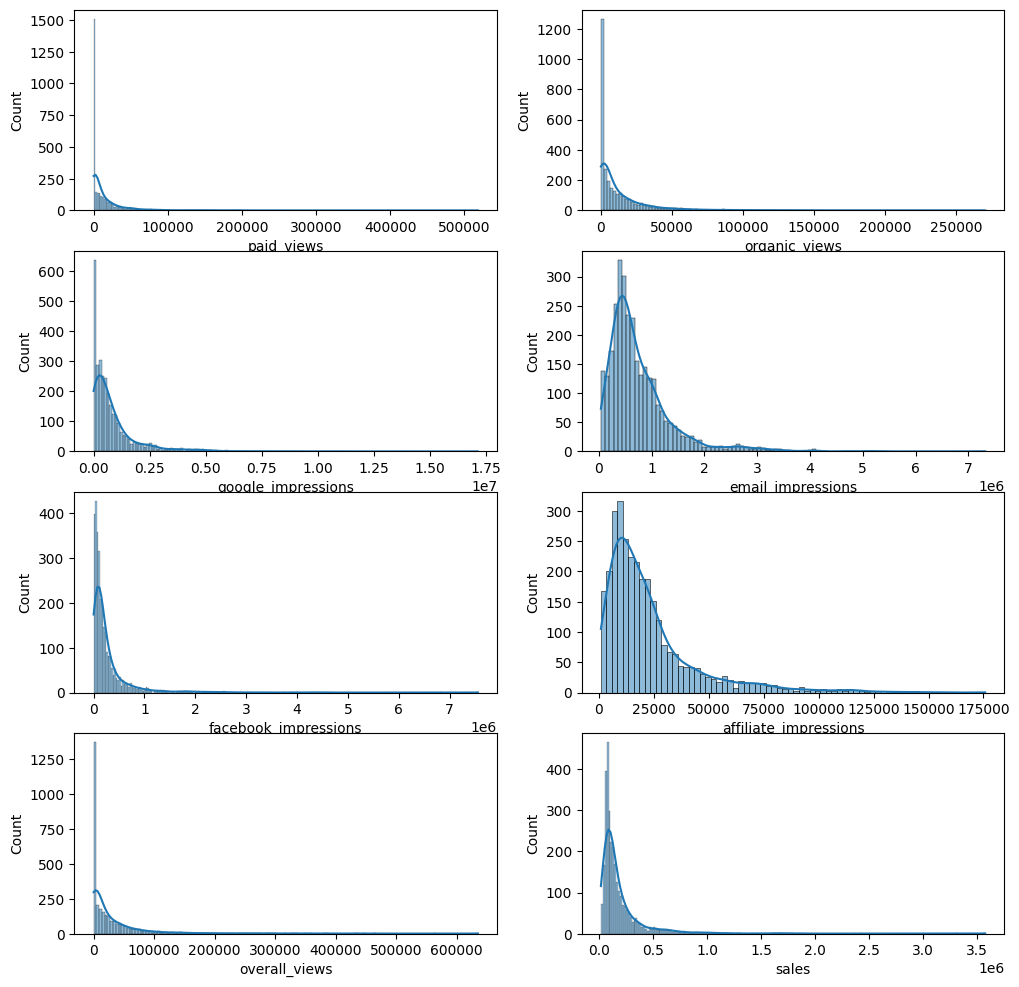

In [53]:
plt.figure(figsize=(12,12))
for n,col in enumerate(numeric_columns):
    plt.subplot(4,2,n+1)
    sns.histplot(df[col], kde =True) # kernel density estimate line

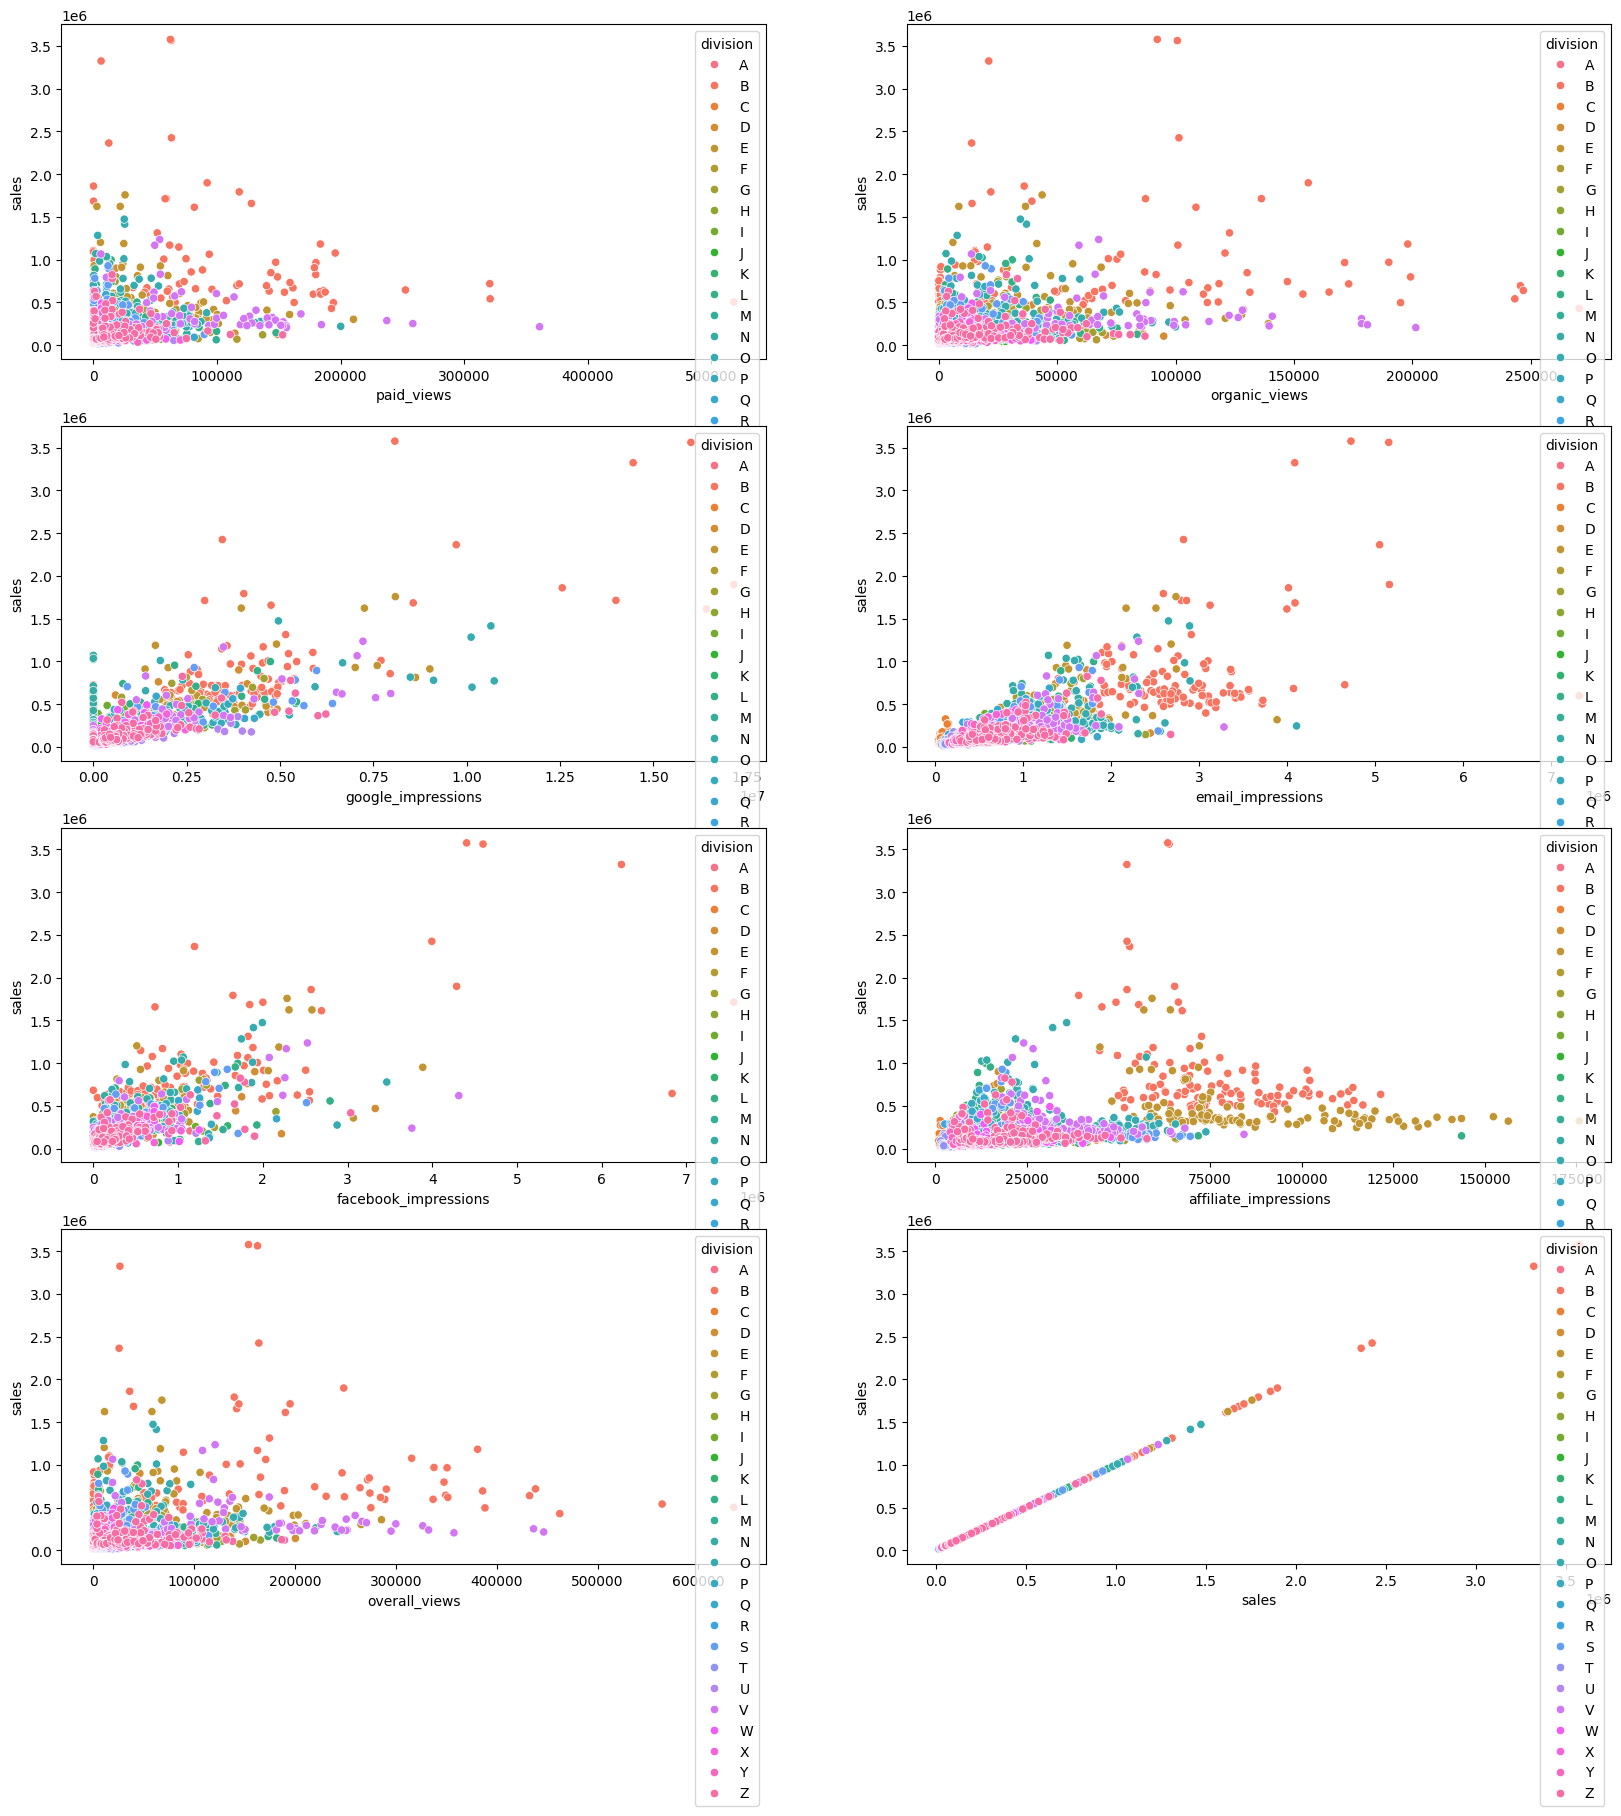

In [54]:
plt.figure(figsize=(20,20))
for n,col in enumerate(numeric_columns):
    plt.subplot(4,2,n+1)
    sns.scatterplot(x = df[col],
                    y= df['sales'],
                    hue = df.division, 
#                     palette = "rocket"
                   )

### Insights
Sales is directly proportional to (important features for model):
- facebook_impressions
- email_impressions
- google_impressions 
- affiliate_impressions


In [55]:
numeric_columns

['paid_views',
 'organic_views',
 'google_impressions',
 'email_impressions',
 'facebook_impressions',
 'affiliate_impressions',
 'overall_views',
 'sales']

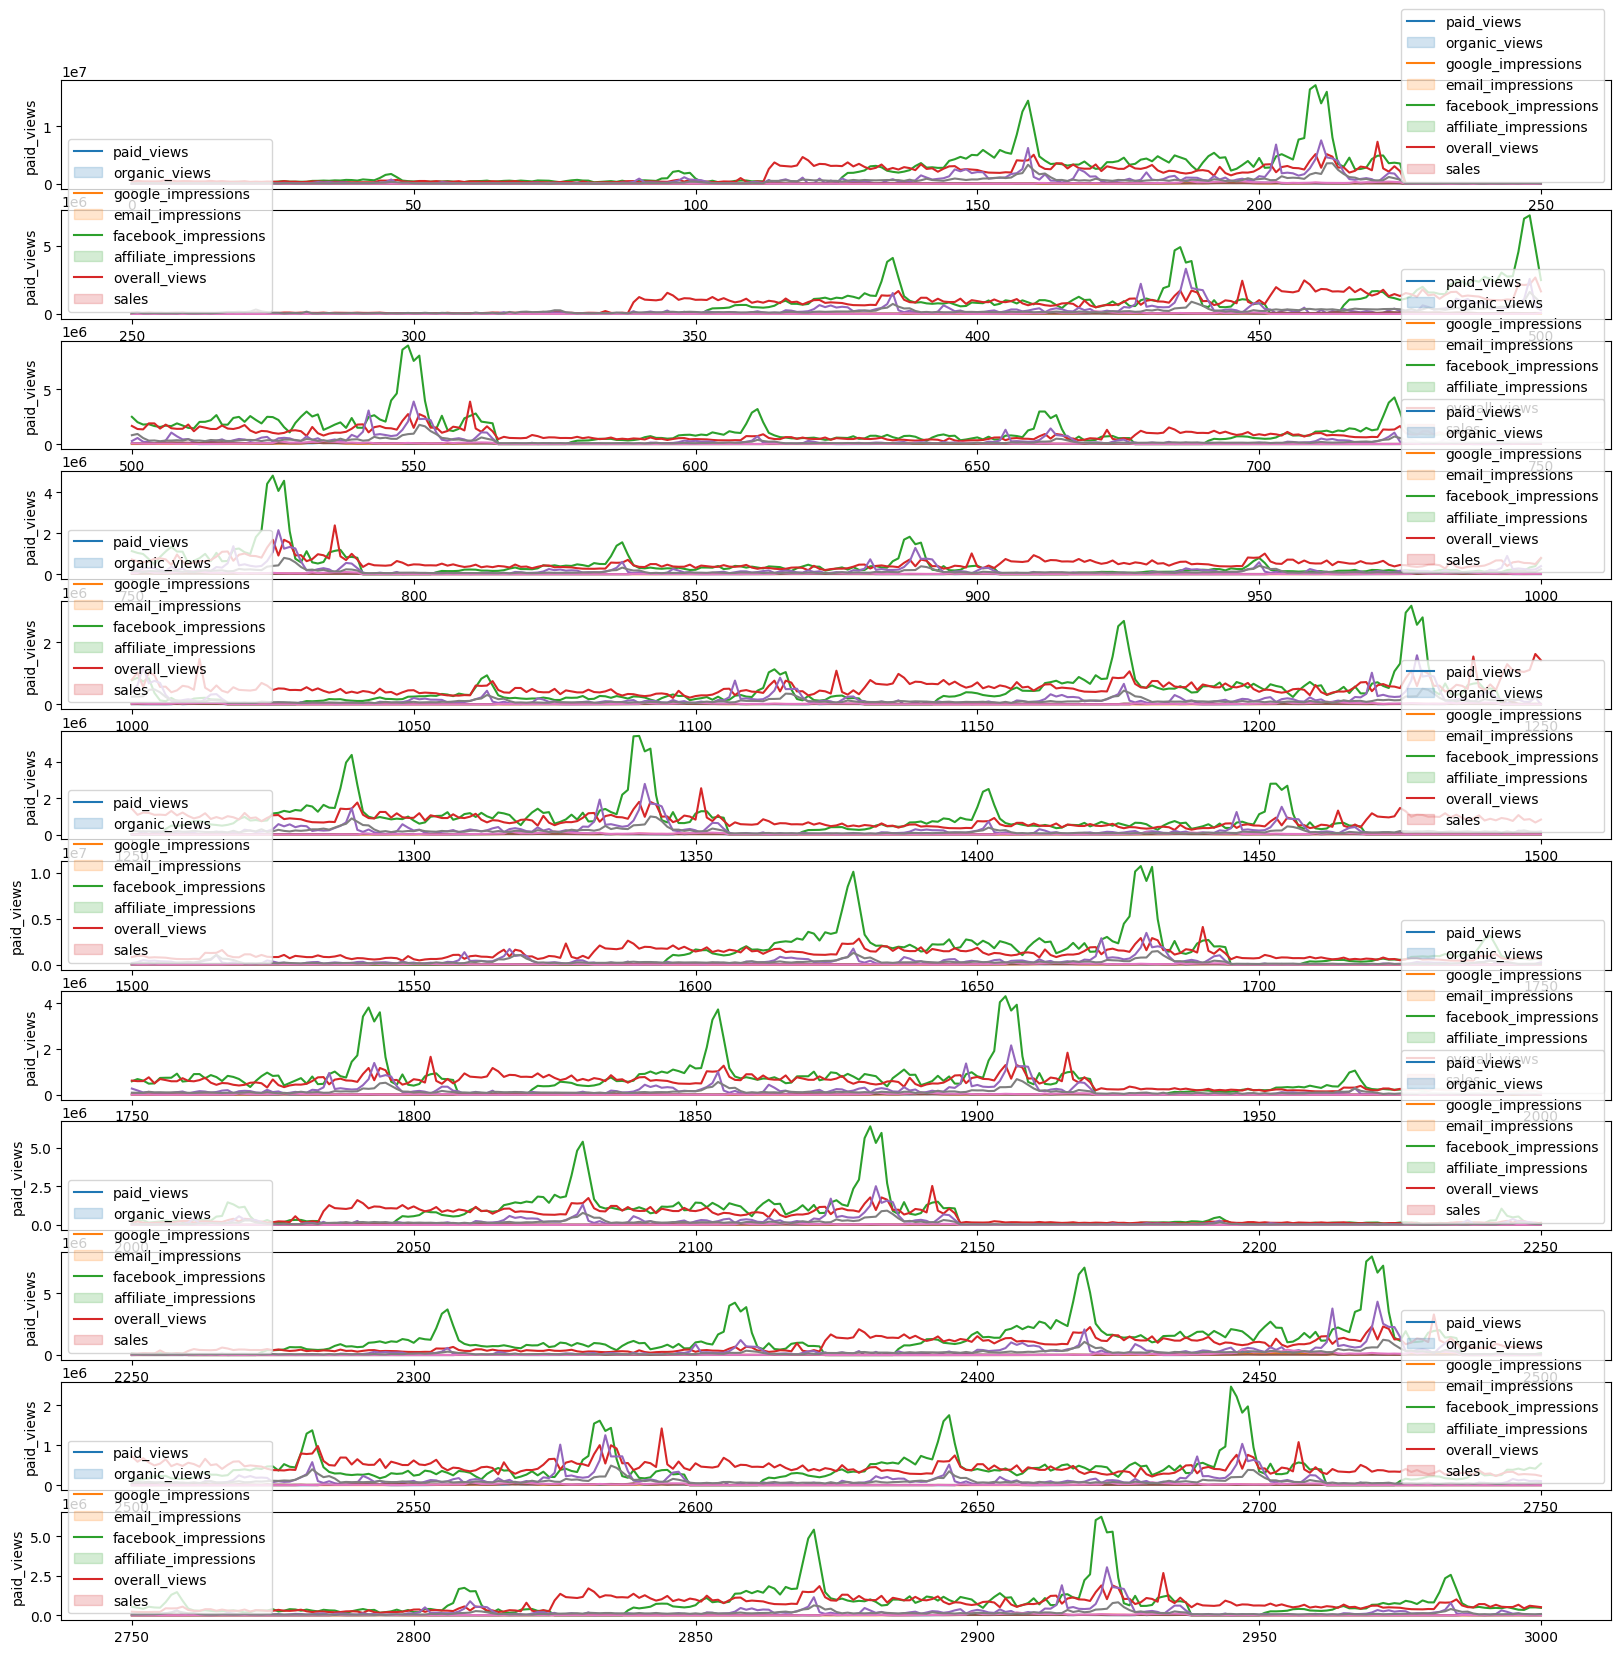

In [56]:
plt.figure(figsize=(20,20))
for n,section in enumerate(range(0,3000,250)):
    plt.subplot(12,1,n+1)
    for i in numeric_columns:
        # select this section and get the column data for the rows in that specified section
        x = df.loc[section:section+250,i]
        sns.lineplot(x)
    plt.legend(numeric_columns)

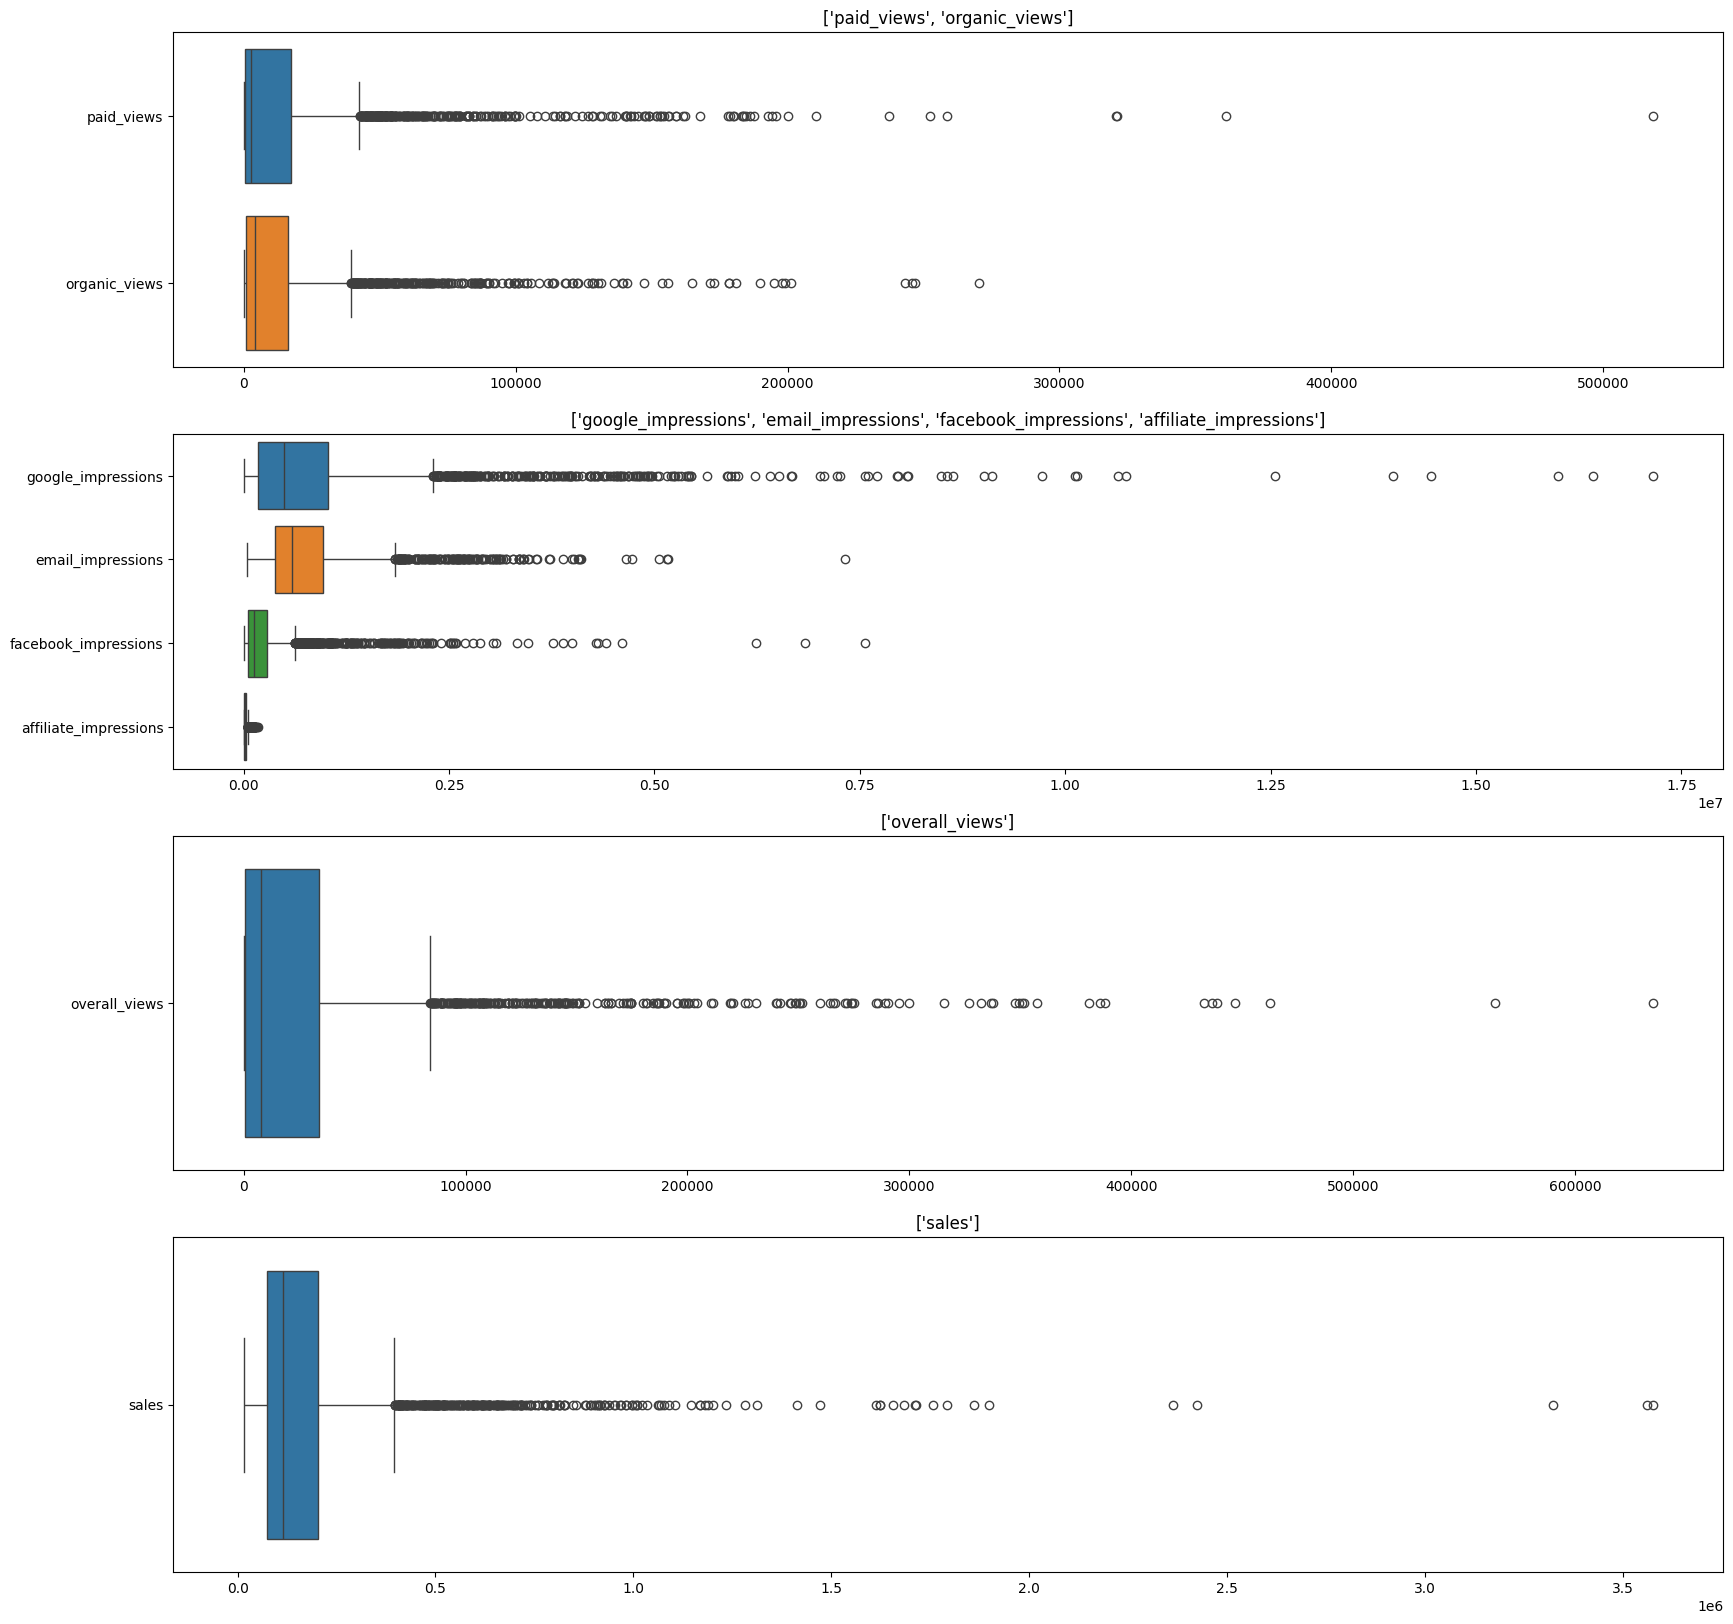

In [57]:
column_batches = [['paid_views', 'organic_views'],['google_impressions', 'email_impressions', 'facebook_impressions',
       'affiliate_impressions',],['overall_views'],['sales']]
plt.figure(figsize=(20,20))
for n,i in enumerate(column_batches):
    plt.subplot(4,1,n+1)
    sns.boxplot(df[i], orient="h")
    plt.title(i)

### Insights 
The given dataset has 
- 3051 rows of data
- 10 columns of which 2 are categorical columns - 'Division', 'Calendar_Week' and remaining are numeric columns.
- categorical columns needed to be converted into numeric values
- None of the columns have null value. No missing value treatment needed
- Week of Year can be split into month, day, year and week number
- Outlier treatment needed
- sales is dirdectly proportional to email_impressions

# Data Cleaning

In [58]:
def treat_outliers(df_in, col):
    q1 = df_in[col].quantile(0.25)
    q3 = df_in[col].quantile(0.75)
    iqr = q3-q1
    upper_bound = q3+1.5*iqr
    df_in[col][df_in[col] >= upper_bound] = upper_bound
    return df_in


In [59]:
fields_to_outlier_treatment = [
    'paid_views',
    'organic_views',
    'google_impressions',
    'email_impressions',
    'facebook_impressions',
    'affiliate_impressions',
    'overall_views',
    'sales'
]
for col in fields_to_outlier_treatment:
    df = treat_outliers(df, col)

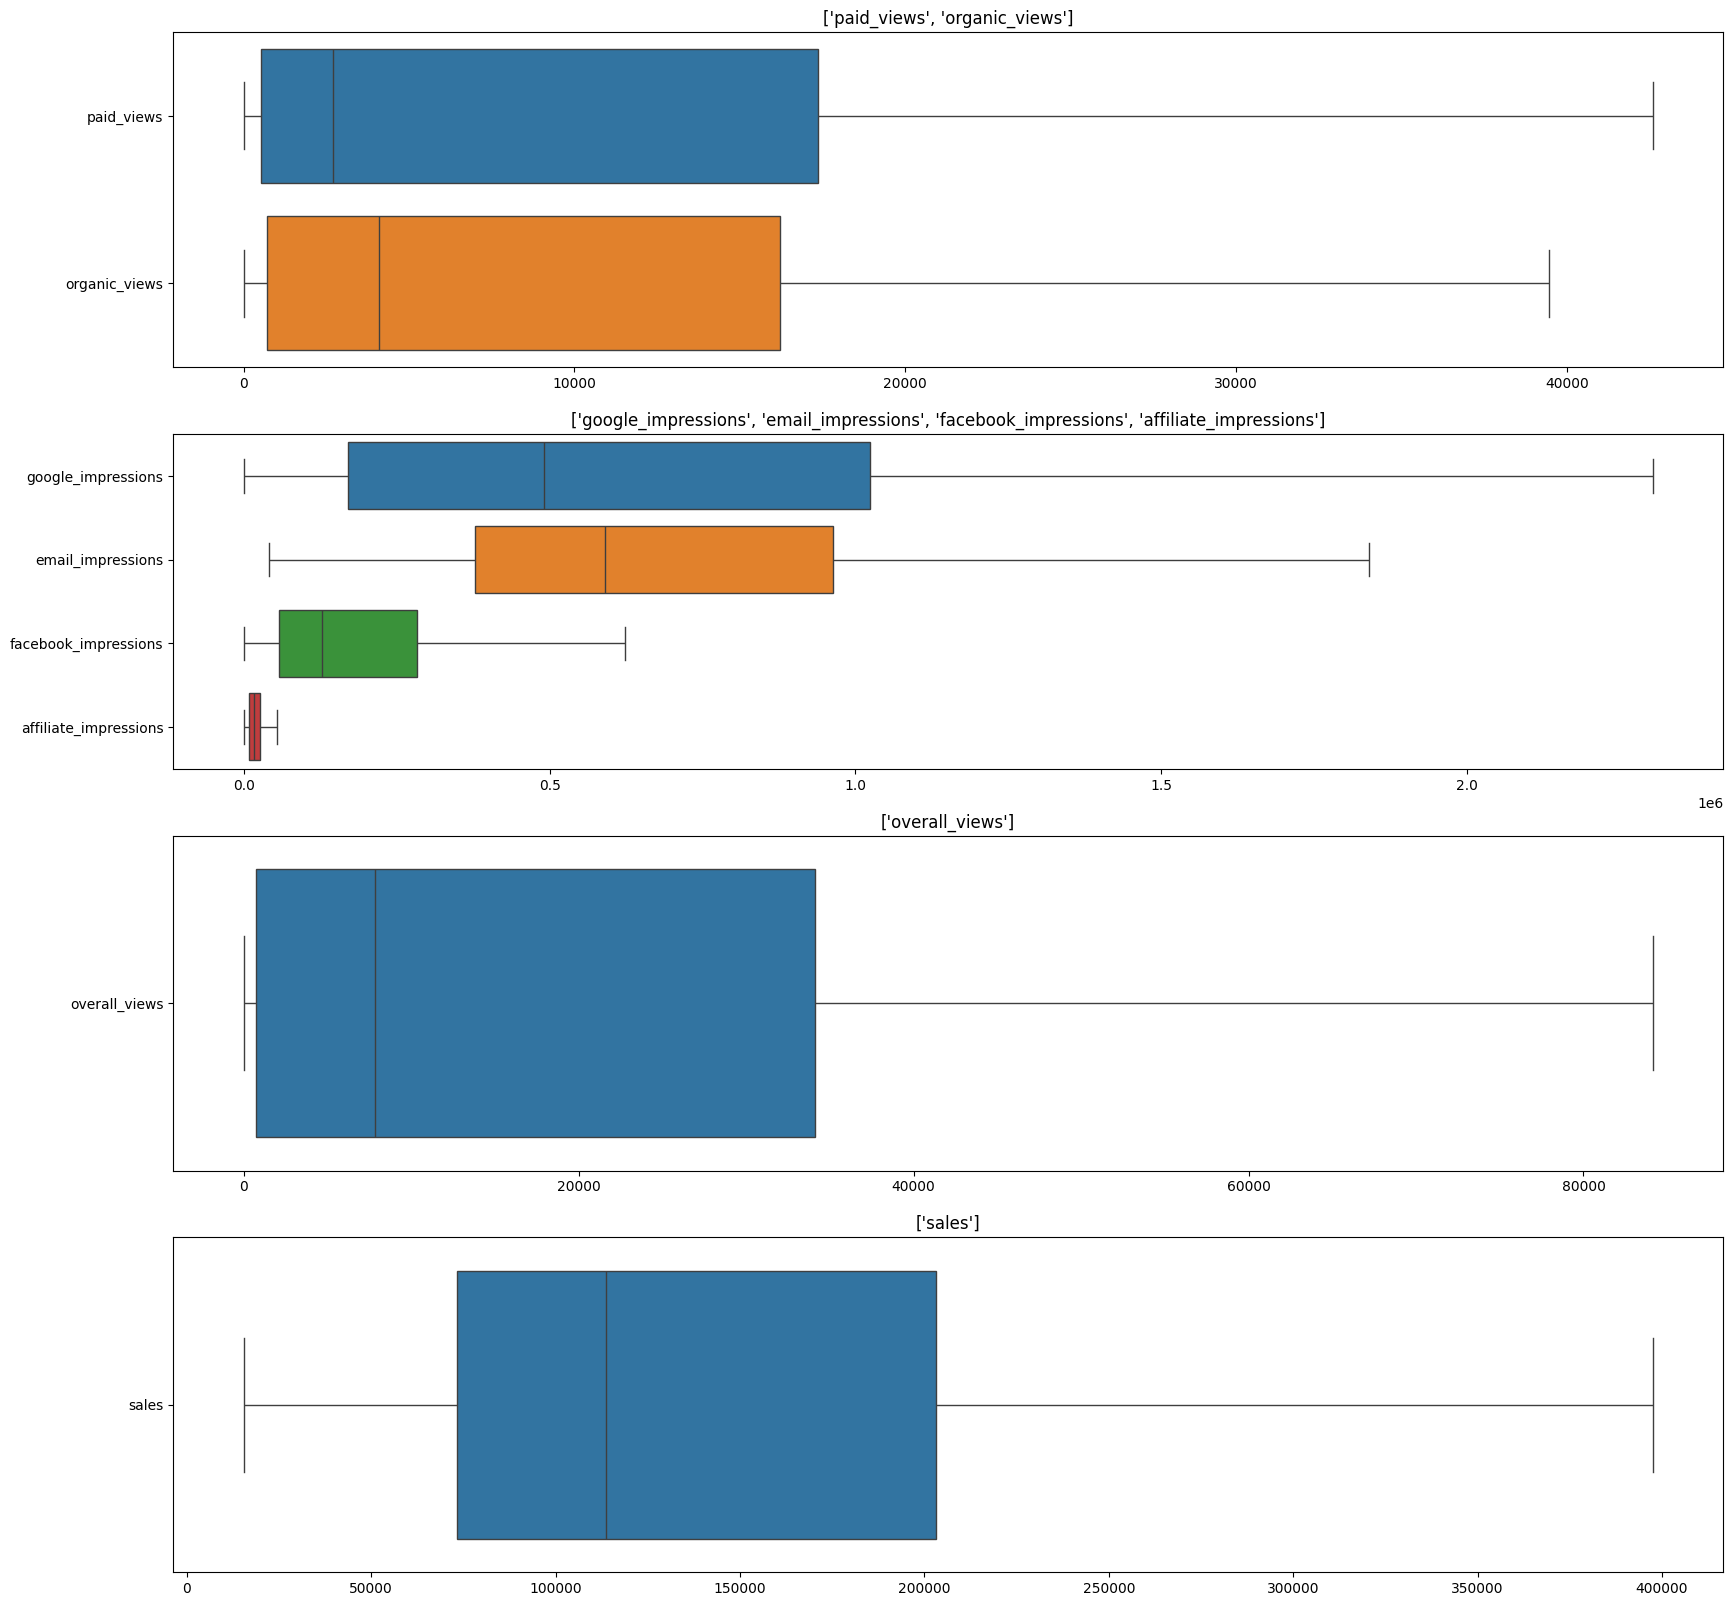

In [60]:
# plotting to check if oultiers are still present
column_batches = [['paid_views', 'organic_views'],['google_impressions', 'email_impressions', 'facebook_impressions',
       'affiliate_impressions',],['overall_views'],['sales']]
plt.figure(figsize=(20,20))
for n,i in enumerate(column_batches):
    plt.subplot(4,1,n+1)
    sns.boxplot(df[i], orient="h")
    plt.title(i)

# Feature Engineering

In [62]:
df['date'] = pd.to_datetime(df['calendar_week'])
df['day'] = [x.day for x in df['date']]
df['week'] = df['date'].dt.isocalendar().week.astype('int')
df['month'] = [x.month for x in df['date']]
df['year'] = [x.year for x in df['date']]
df.year.value_counts(), df.month.value_counts(), df.day.value_counts(), df['week'].value_counts()

(year
 2018    1404
 2019    1404
 2020     242
 Name: count, dtype: int64,
 month
 2     350
 1     324
 3     270
 6     270
 8     243
 9     243
 11    243
 12    243
 4     216
 5     216
 7     216
 10    216
 Name: count, dtype: int64,
 day
 6     108
 23    108
 9     108
 2     108
 1     108
 13    108
 8     108
 15    108
 28    108
 21    108
 14    108
 7     108
 22    108
 24    108
 17    108
 10    108
 3     108
 27    108
 20    108
 16    108
 29    107
 30     81
 4      81
 11     81
 18     81
 25     81
 26     81
 12     81
 5      81
 19     81
 31     54
 Name: count, dtype: int64,
 week
 1     81
 3     81
 4     81
 5     81
 6     81
 7     81
 8     81
 2     81
 9     80
 36    54
 39    54
 38    54
 37    54
 33    54
 35    54
 34    54
 41    54
 40    54
 45    54
 42    54
 43    54
 44    54
 31    54
 46    54
 47    54
 48    54
 49    54
 50    54
 51    54
 32    54
 27    54
 30    54
 18    54
 10    54
 11    54
 12    54
 13    54
 14    

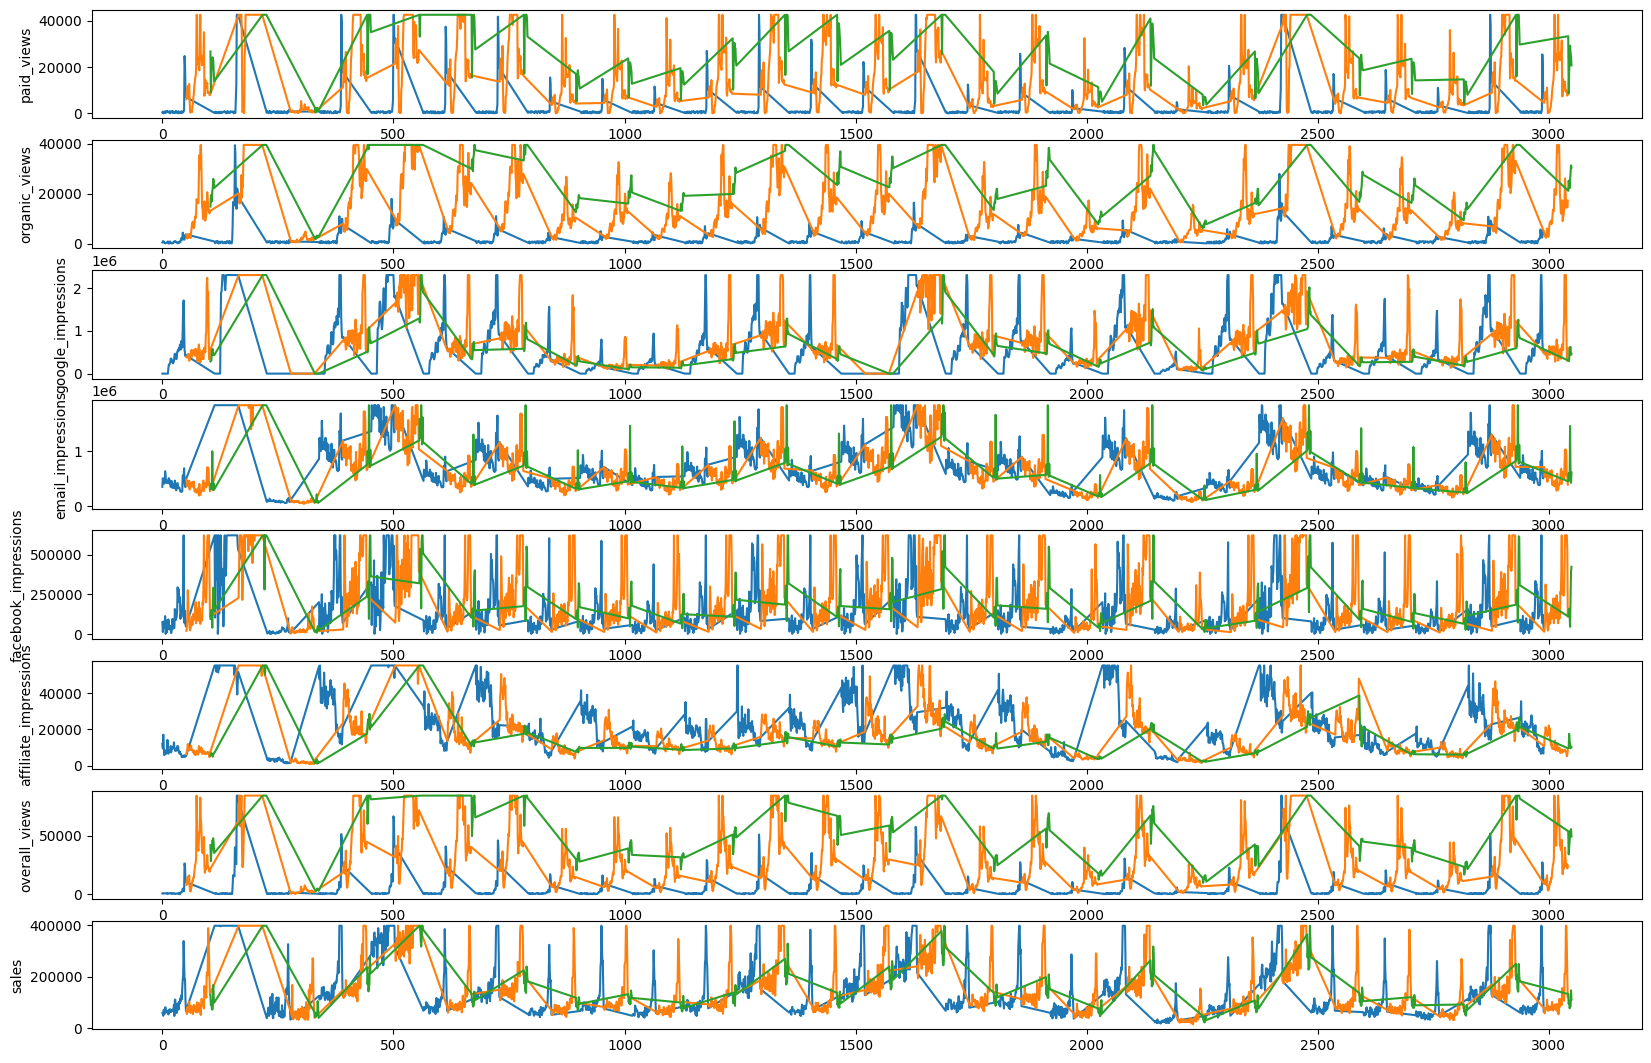

In [64]:
plt.figure(figsize=(20,20))
for n,i in enumerate(numeric_columns):
    plt.subplot(12,1,n+1)
    sns.lineplot(df.loc[df.year == 2018,i])
    sns.lineplot(df.loc[df.year == 2019,i])
    sns.lineplot(df.loc[df.year == 2020,i])
#     plt.legend(df.year)

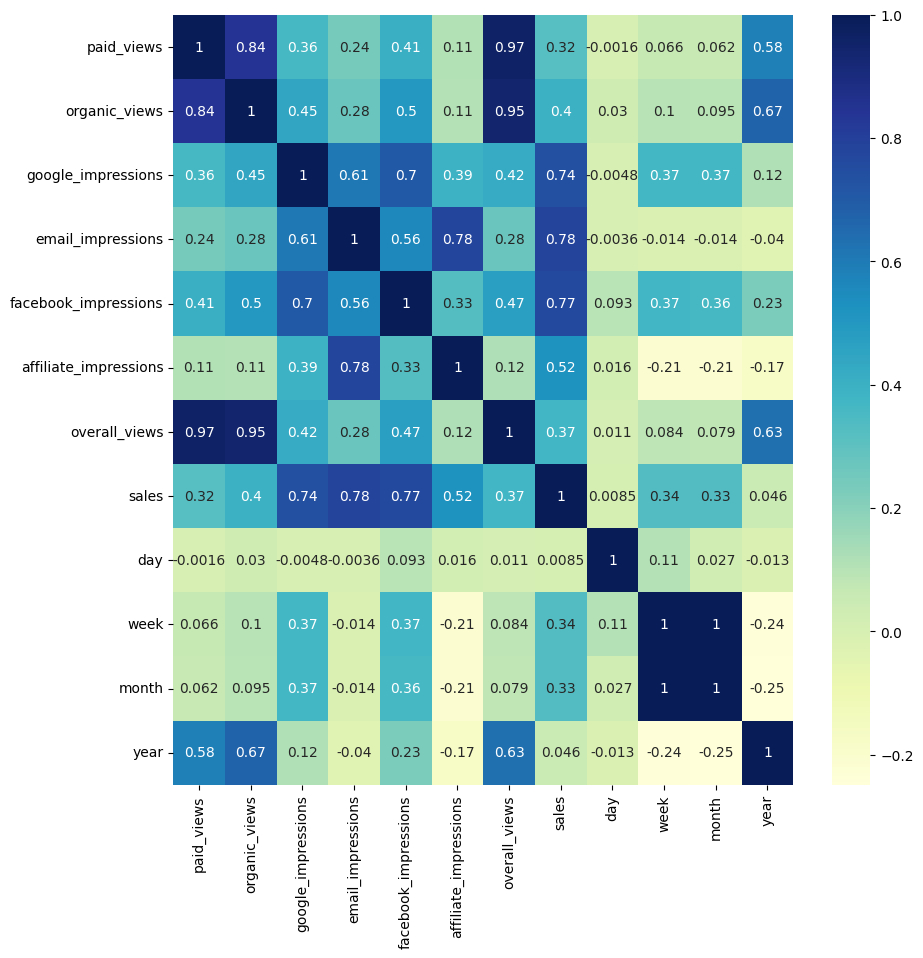

In [65]:
numeric_columns,_ = get_num_cat_columns(df)
plt.figure(figsize=(10,10))
sns.heatmap(df[numeric_columns].corr(), cmap="YlGnBu", annot=True);

#### Insights : High Coorelation
Amoung highly coorelated features we should keep only one of these features in the final model.
- month and week is highly coorelated.
- overall_views is highly correlated with paid_views and organic_views. paid_views and organic_views are highly coorelated.
- affiliate_impressions and email_impressions are highly coorelated.
- facebook_impressions and google_impressions are highly coorelated.
- We will use VIF to check if this coorelation impacts the model.


Sales has Highest Correlation with (important features for model):
- facebook_impressions, 
- email_impressions, 
- google_impressions and 
- affiliate_impressions



# Adjusting for Adstock Effect
When any advertisement is released, its impacts on sales decays over time. We need to calculate adjust the ad variable so that we accomodate for the decay effect when understanding their relationship with sales.

In [66]:
# AdStock Effect
def calculate_adstock_effect(decay_constant, ad_variable_list):
    """
    Models the "memory" effect of advertising
    Accounts for diminishing returns, models input values over time logarithmically 
    Captures carryover effects from previous periods

    Args:
        decay_constant (numpy.float64): Rate at which advertising effect diminishes (between 0-1)
        ad_variable_list (list): column values for a specific column in adstock_variables

    Returns:
        list : _description_
    """
    adstock_list = []
    for i in range(len(ad_variable_list)):
        ad_variable = ad_variable_list[i]
        if i == 0:
            adstock = np.log(ad_variable)
            adstock_list.append(adstock)
        else:
            # This captures how advertising continues to have impact even after spending stops
            adstock = np.log(ad_variable) + (decay_constant*adstock_list[i-1])
            adstock_list.append(adstock)
    return adstock_list

In [67]:
# calculate_adstock_effect(0.1,[1,2,3,5,3,6])

In [68]:
adstock_variables = [
    'paid_views',
     'organic_views',
     'google_impressions',
     'email_impressions',
     'facebook_impressions',
     'affiliate_impressions',
     'overall_views'
]
decay_constant_list = np.arange(0.1,0.4,0.2)

In [69]:
for col in adstock_variables:
    for decay in decay_constant_list:
        decay = round(decay,2)
        col_name = f"{col}_{decay}"
        print(col_name)
        df[col_name] = calculate_adstock_effect(decay, df[col])

paid_views_0.1
paid_views_0.3
organic_views_0.1
organic_views_0.3
google_impressions_0.1
google_impressions_0.3
email_impressions_0.1
email_impressions_0.3
facebook_impressions_0.1
facebook_impressions_0.3
affiliate_impressions_0.1
affiliate_impressions_0.3
overall_views_0.1
overall_views_0.3


In [70]:
dummy_df = df[['month','division']].copy()
dummy_df['month']= dummy_df['month'].astype('str')
dummy_df = pd.get_dummies(dummy_df).astype('float')
dummy_df = pd.concat([df, dummy_df], axis = 1)
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   division                   3050 non-null   object        
 1   calendar_week              3050 non-null   object        
 2   paid_views                 3050 non-null   int64         
 3   organic_views              3050 non-null   float64       
 4   google_impressions         3050 non-null   float64       
 5   email_impressions          3050 non-null   float64       
 6   facebook_impressions       3050 non-null   float64       
 7   affiliate_impressions      3050 non-null   float64       
 8   overall_views              3050 non-null   float64       
 9   sales                      3050 non-null   int64         
 10  date                       3050 non-null   datetime64[ns]
 11  day                        3050 non-null   int64         
 12  week  

In [71]:
dummy_df.describe()

,paid_views,organic_views,google_impressions,email_impressions,facebook_impressions,affiliate_impressions,overall_views,sales,date,day,...,division_Q,division_R,division_S,division_T,division_U,division_V,division_W,division_X,division_Y,division_Z
count,3050.000000,3050.00000,3.050000e+03,3.050000e+03,3050.000000,3050.000000,3050.000000,3050.000000,3050,3050.000000,...,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.000000,3050.00000
mean,10828.893770,10345.60041,7.167383e+05,7.141727e+05,201759.323893,20834.372828,21420.529549,155024.649508,2019-02-01 20:54:55.475409920,15.677049,...,0.037049,0.037049,0.037049,0.037049,0.037049,0.037049,0.037049,0.037049,0.037049,0.07377
min,1.000000,1.00000,7.000000e+00,4.089445e+04,29.000000,910.000000,2.000000,15436.000000,2018-01-06 00:00:00,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,536.000000,712.25000,1.698070e+05,3.784388e+05,57070.250000,9121.500000,747.000000,73392.250000,2018-07-21 00:00:00,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,2689.500000,4103.00000,4.905315e+05,5.912425e+05,127508.000000,16661.000000,7838.500000,113685.000000,2019-02-02 00:00:00,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,17362.000000,16209.50000,1.023151e+06,9.625489e+05,283516.500000,27487.250000,34102.750000,203037.750000,2019-08-17 00:00:00,23.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,42601.000000,39455.37500,2.303166e+06,1.838714e+06,623185.875000,55035.875000,84136.375000,397506.000000,2020-02-29 00:00:00,31.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
std,14174.300102,12697.44306,7.134956e+05,4.659119e+05,191419.788010,15325.414207,27221.577524,109951.798863,NaN,8.805520,...,0.188913,0.188913,0.188913,0.188913,0.188913,0.188913,0.188913,0.188913,0.188913,0.26144


In [72]:
mmxdf= dummy_df.drop(['date','division','calendar_week'], axis=1)

In [73]:
mmxdf.columns

Index(['paid_views', 'organic_views', 'google_impressions',
       'email_impressions', 'facebook_impressions', 'affiliate_impressions',
       'overall_views', 'sales', 'day', 'week', 'month', 'year',
       'paid_views_0.1', 'paid_views_0.3', 'organic_views_0.1',
       'organic_views_0.3', 'google_impressions_0.1', 'google_impressions_0.3',
       'email_impressions_0.1', 'email_impressions_0.3',
       'facebook_impressions_0.1', 'facebook_impressions_0.3',
       'affiliate_impressions_0.1', 'affiliate_impressions_0.3',
       'overall_views_0.1', 'overall_views_0.3', 'month_1', 'month_10',
       'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'division_A', 'division_B',
       'division_C', 'division_D', 'division_E', 'division_F', 'division_G',
       'division_H', 'division_I', 'division_J', 'division_K', 'division_L',
       'division_M', 'division_N', 'division_O', 'division_P', 'division_Q',
       'divi

In [74]:
# Data Scaling
# X_scaled = (X - X_min) / (X_max - X_min)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns_to_scale = ['paid_views', 'organic_views', 'google_impressions',
       'email_impressions', 'facebook_impressions', 'affiliate_impressions',
       'overall_views', 'day', 'week', 'month', 'year',
       'paid_views_0.1', 'paid_views_0.3', 'organic_views_0.1',
       'organic_views_0.3', 'google_impressions_0.1', 'google_impressions_0.3',
       'email_impressions_0.1', 'email_impressions_0.3',
       'facebook_impressions_0.1', 'facebook_impressions_0.3',
       'affiliate_impressions_0.1', 'affiliate_impressions_0.3',
       'overall_views_0.1', 'overall_views_0.3', 'month_1', 'month_10',
       'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'division_A', 'division_B',
       'division_C', 'division_D', 'division_E', 'division_F', 'division_G',
       'division_H', 'division_I', 'division_J', 'division_K', 'division_L',
       'division_M', 'division_N', 'division_O', 'division_P', 'division_Q',
       'division_R', 'division_S', 'division_T', 'division_U', 'division_V',
       'division_W', 'division_X', 'division_Y', 'division_Z']
mmxdf[columns_to_scale] = scaler.fit_transform(mmxdf[columns_to_scale])

# Model Preparation

In [75]:
from sklearn.model_selection import train_test_split

mmx_train, mmx_test = train_test_split(mmxdf, train_size = 0.7, test_size = 0.3, random_state = 100)
x_train, y_train = mmx_train[columns_to_scale], mmx_train['sales']
x_test, y_test = mmx_test[columns_to_scale], mmx_test['sales']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score # Measures how well a model explains the variability in the target variable (like sales in MMM)
# r2_score = 1 - (Sum of Squared Residuals / Total Sum of Squares) = 1 - (Σ(y_true - y_pred)² / Σ(y_true - y_mean)²)
from sklearn.linear_model import LinearRegression

# Baseline Model
lm = LinearRegression()
# Performing cross-validation to evaluate a linear regression model
# Splits data into 10 folds, for total of 30 train-test splits
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lm, x_train, y_train, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
# Shows model performance (mean) and consistency (std)
print('R-Squared Error: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

R-Squared Error: 0.899 (0.015)


# Model Building

In [81]:
# VIF (Variance Inflation Factor) is a measure used to detect multicollinearity in regression models. 
# Multicollinearity occurs when independent variables (features) are highly correlated with each other.

import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_selection_using_vif(X_train, y_train):
    features_to_keep = list(X_train.columns)
    vif_threshold = 10
    
    while True:
        # Build the model
        X_train_with_const = sm.add_constant(X_train)
        model = sm.OLS(y_train, X_train_with_const) # Ordinary Least Squares - basic linear regression model from the statsmodels library
        result = model.fit()
#         print(result.summary())
        
        # Calculate VIF
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_train.columns
        vif_data["VIF"] = [round(variance_inflation_factor(X_train.values, i),2) for i in range(X_train.shape[1])]
        vif_data = vif_data.sort_values(by = "VIF", ascending = False)
        
        # Find feature with highest VIF
        max_vif_feature = vif_data.loc[vif_data["VIF"].idxmax()]
        max_vif = max_vif_feature["VIF"]
        if max_vif <= vif_threshold:
            break
        
        # Remove feature with highest VIF
        feature_to_drop = max_vif_feature["Feature"]
        print(f"feature_to_drop: {feature_to_drop}, vif: {max_vif}")
        features_to_keep.remove(feature_to_drop)
        X_train = X_train[features_to_keep]
    
    return X_train


In [82]:
X_train_fs = feature_selection_using_vif(x_train,y_train)

feature_to_drop: month_4, vif: inf
feature_to_drop: month_5, vif: inf
feature_to_drop: month_3, vif: inf
feature_to_drop: week, vif: 1299485.04
feature_to_drop: affiliate_impressions_0.3, vif: 491.27
feature_to_drop: overall_views_0.3, vif: 354.79
feature_to_drop: google_impressions_0.3, vif: 303.3
feature_to_drop: email_impressions_0.1, vif: 274.34
feature_to_drop: organic_views_0.3, vif: 213.82
feature_to_drop: division_Z, vif: 177.38
feature_to_drop: facebook_impressions_0.1, vif: 2691.84
feature_to_drop: paid_views_0.1, vif: 1485.74
feature_to_drop: email_impressions_0.3, vif: 563.66
feature_to_drop: month, vif: 327.86
feature_to_drop: overall_views, vif: 234.85
feature_to_drop: affiliate_impressions_0.1, vif: 214.5
feature_to_drop: overall_views_0.1, vif: 137.32
feature_to_drop: facebook_impressions_0.3, vif: 107.09
feature_to_drop: organic_views_0.1, vif: 84.19
feature_to_drop: paid_views_0.3, vif: 53.04
feature_to_drop: google_impressions_0.1, vif: 34.44
feature_to_drop: email_i

In [83]:
features_to_use = X_train_fs.columns
features_to_use
# X_train_rfe.columns

Index(['paid_views', 'google_impressions', 'facebook_impressions', 'day',
       'year', 'month_1', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_6', 'month_7', 'month_8', 'month_9', 'division_A', 'division_B',
       'division_C', 'division_D', 'division_E', 'division_F', 'division_G',
       'division_H', 'division_I', 'division_J', 'division_K', 'division_L',
       'division_M', 'division_N', 'division_O', 'division_P', 'division_Q',
       'division_R', 'division_S', 'division_T', 'division_U', 'division_V',
       'division_W', 'division_X', 'division_Y'],
      dtype='object')

### Insights : Features removed due to high coorelation
- organic_views, overall_views
- email_impressions
- affiliate_impressions
- week, month

as anticipated through coorelation heatmap

In [84]:
# Testing Score
lm = LinearRegression()
lm.fit(X_train_fs, y_train)
pred = lm.predict(x_test[features_to_use])
print('Testing Score R-Squared Error: %.3f ' % (r2_score(y_test, pred)))

Testing Score R-Squared Error: 0.872 


In [85]:
# Storing the model in a pickle file
import pickle
pickle.dump(lm, open('model.pkl', 'wb'))

In [ ]:
# Loading a stored model from a pickle file
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(x_test[features_to_use][:1])
# The output should be a sales value

array([377525.24403596])

In [ ]:
x_test[features_to_use][:1]

,paid_views,google_impressions,facebook_impressions,day,year,month_1,month_10,month_11,month_12,month_2,...,division_P,division_Q,division_R,division_S,division_T,division_U,division_V,division_W,division_X,division_Y
147,0.021315,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
y_test[:1]

147    397506
Name: sales, dtype: int64

In [90]:
def predict_sales(df:pd.DataFrame)->float:
    """Predicts sales using a trained model

    Args:
        df (pd.DataFrame): data for forcasting

    Returns:
        float: forecast of sales
    """
    # Data Preprocessing
    df = df.reset_index(drop = True)
    df.columns = map(str.lower, df.columns)
    df['date'] = pd.to_datetime(df['calendar_week'])
    df['day'] = [x.day for x in df['date']]
    df['week'] = df['date'].dt.isocalendar().week.astype('int')
    df['month'] = [x.month for x in df['date']]
    df['year'] = [x.year for x in df['date']]
    
    # Encoding Categorical Features
    dummy_df = df[['month','division']].copy()
    dummy_df['month']= dummy_df['month'].astype('str')
    dummy_df = pd.get_dummies(dummy_df).astype('float')
    dummy_df = pd.concat([df, dummy_df], axis = 1)    
    mmxdf= dummy_df.drop(['date','division','calendar_week'], axis=1)
    missing_columns = [col for col in columns_to_scale if col not in mmxdf.columns]
    mmxdf[missing_columns] = 0
    mmxdf[columns_to_scale] = scaler.transform(mmxdf[columns_to_scale])
    
    # Getting Model Prediction
    pickled_model = pickle.load(open('model.pkl', 'rb'))
    pred = pickled_model.predict(mmxdf[features_to_use])
    return pred

In [91]:
final_test

,division,calendar_week,paid_views,organic_views,google_impressions,email_impressions,facebook_impressions,affiliate_impressions,overall_views,sales
3049,Z,2/22/2020,20713,30356,464178,608579.9078,424676,10221,49221,111525


In [92]:
predict_sales(final_test)

array([164780.14611142])

## With that our Market Mix Model is ready! 
We can use this model to forecast sales based on 
```['division', 'calendar_week', 'paid_views', 'organic_views','google_impressions', 'email_impressions', 'facebook_impressions','affiliate_impressions', 'overall_views']```
using ```predict_sales()``` function which prepares the data to feed into the model and then get the predicted sales.